In [1]:
import requests
import textacy
from functools import partial
import numpy as np
import spacy
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import textacy.tm
import warnings
import gensim
import gensim.downloader as api
import matplotlib
import time
import datetime
from collections import Counter

warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
model_glove = api.load("glove-wiki-gigaword-100")
lang = 'fr_core_news_lg'

In [19]:
df1 = pd.read_csv('tweets_1_tierslieux_19024.csv')
df1 = df1.sort_values(by=['timestamp_utc'], ascending=True,ignore_index=True)

df2 = pd.read_csv('tweets_2_tierslieu_6038.csv')
df2 = df2.sort_values(by=['timestamp_utc'], ascending=True,ignore_index=True)

df1.columns

Index(['query', 'id', 'timestamp_utc', 'local_time', 'user_screen_name',
       'text', 'possibly_sensitive', 'retweet_count', 'like_count',
       'reply_count', 'lang', 'to_username', 'to_userid', 'to_tweetid',
       'source_name', 'source_url', 'user_location', 'lat', 'lng', 'user_id',
       'user_name', 'user_verified', 'user_description', 'user_url',
       'user_image', 'user_tweets', 'user_followers', 'user_friends',
       'user_likes', 'user_lists', 'user_created_at', 'user_timestamp_utc',
       'collected_via', 'match_query', 'retweeted_id', 'retweeted_user',
       'retweeted_user_id', 'retweeted_timestamp_utc', 'quoted_id',
       'quoted_user', 'quoted_user_id', 'quoted_timestamp_utc',
       'collection_time', 'url', 'place_country_code', 'place_name',
       'place_type', 'place_coordinates', 'links', 'domains', 'media_urls',
       'media_files', 'media_types', 'mentioned_names', 'mentioned_ids',
       'hashtags', 'intervention_type', 'intervention_text',
       'in

In [20]:
df_combined = pd.DataFrame(columns=['id','text','hashtags','timestamp_utc','year','month','day'])

for temp_df in [df1,df2]:
    new_df = pd.DataFrame(columns=['id','text','hashtags','timestamp_utc','year','month','day'])
    for cols in ['id','text','hashtags','timestamp_utc']:
        new_df[cols] = temp_df[cols]

    date = pd.to_datetime(temp_df['timestamp_utc'], unit='s')
    new_df['year'] = pd.DatetimeIndex(date).year
    new_df['month'] = pd.DatetimeIndex(date).month
    new_df['day'] = pd.DatetimeIndex(date).day

    df_combined = pd.concat([df_combined,new_df])

df_combined = df_combined.drop_duplicates(ignore_index=True)
df_combined = df_combined.sort_values(by=['timestamp_utc'], ascending=True,ignore_index=True)

ori_hashtag = df_combined['hashtags']

for i, hasht in enumerate(ori_hashtag):
    temp_hasht = hasht.split('|')
    temp_hasht = [ht for ht in temp_hasht if ht!='tierslieux']
    temp_hasht = [ht for ht in temp_hasht if ht!='tierslieu']
    ori_hashtag[i] = temp_hasht

df_combined['hashtags'] = ori_hashtag
df_combined.to_csv('tweets_combined.csv')
df_combined.head()

,id,text,hashtags,timestamp_utc,year,month,day
0,2408979548344320,"RT @fbon: La ""non bibliothèque"" de Chris Meade...",[],1289409320,2010,11,10
1,4884796241088512,"""Impact des nvx modes de travail [= #teletrava...",[teletravail],1289999600,2010,11,17
2,27334783331729408,#thirdplace #tierslieux #EnUnMot RT @hughpearm...,"[enunmot, thirdplace]",1295352094,2011,1,18
3,36102389715058688,observe les amoureux qui s'bécotent sur les ma...,[],1297442455,2011,2,11
4,43616655615594496,#Tierslieu#Aubervilliers http://sebastienlucas...,[tierslieu#aubervilliers],1299233995,2011,3,4


In [21]:
years = list(np.unique(df_combined['year']))
years

[2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]

In [16]:
def plot_freq(k,dat_val,dat_key,label):

    fig, ax = plt.subplots(1,1,figsize=(25,8))

    ax.bar(x=range(k),height=dat_val[:k],label=label)
    ax.set_xticks(range(k))
    ax.set_xticklabels(dat_key[:k],rotation=30,fontsize=25,horizontalalignment='right')

    ax.set_ylabel('Frequency',fontsize=25)

    ax.tick_params(axis='both', which='major', labelsize=25, length=10, width=2)

    ax.legend(frameon=False,fontsize=25)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    plt.tight_layout()
    plt.savefig('tweets_most_mentioned_'+label+'.jpeg',dpi=100)
    # plt.show()

2011  is done.
2012  is done.
2013  is done.
2014  is done.
2015  is done.
2016  is done.
2017  is done.
2018  is done.
2019  is done.
2020  is done.


/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 11088 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 11088 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128071 missing from current font.
  font.set_text(s, 0, flags=flags)


2021  is done.


/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128205 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 128064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 127479 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128205 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 128064 missing from current font.
  font.set_text(s, 0, flags=flags)
/home/onkar/anaconda2/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203:

2022  is done.


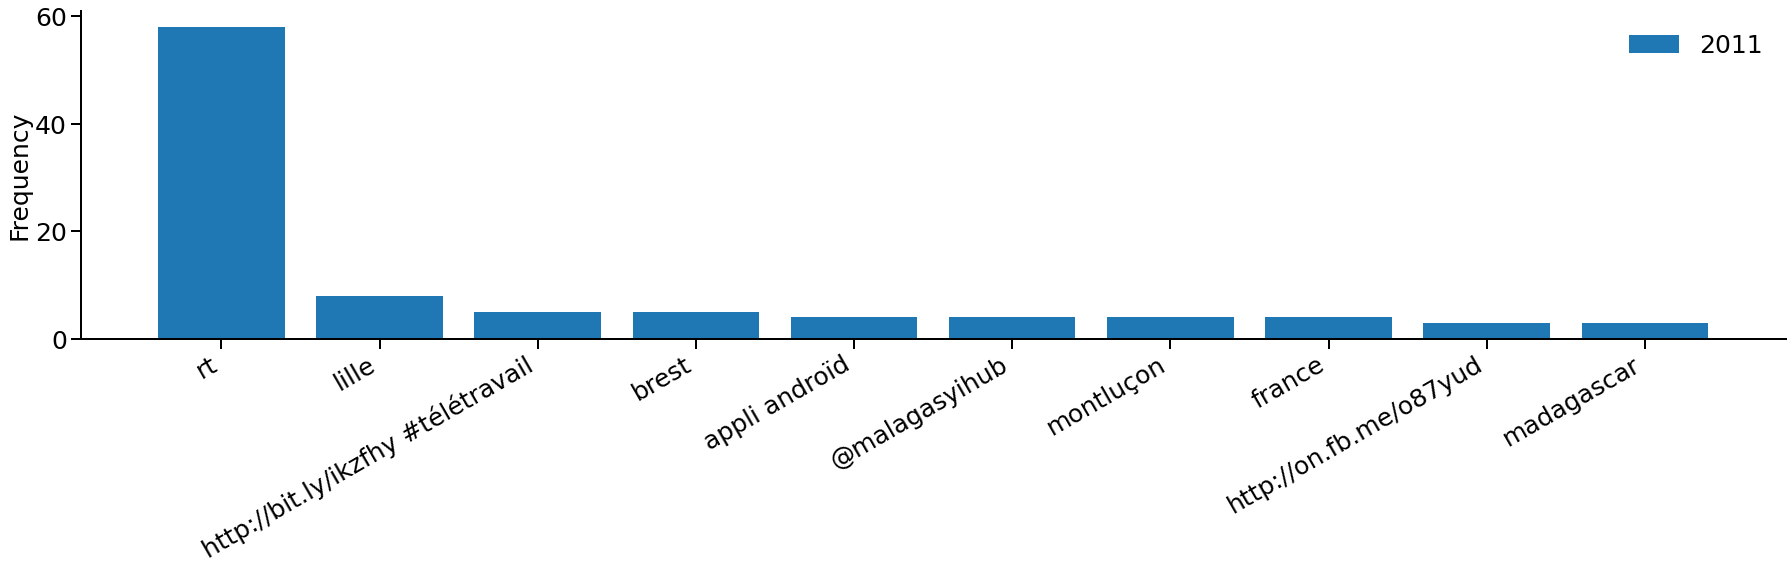

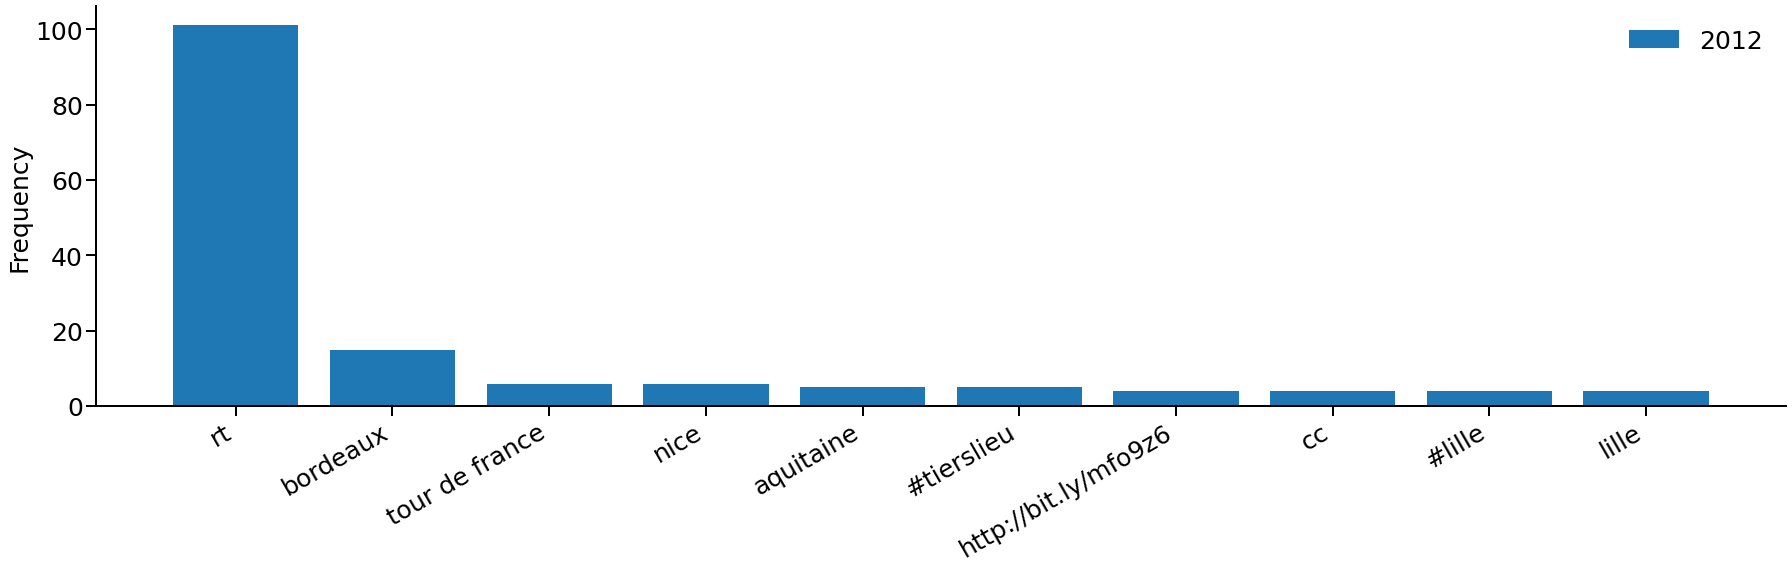

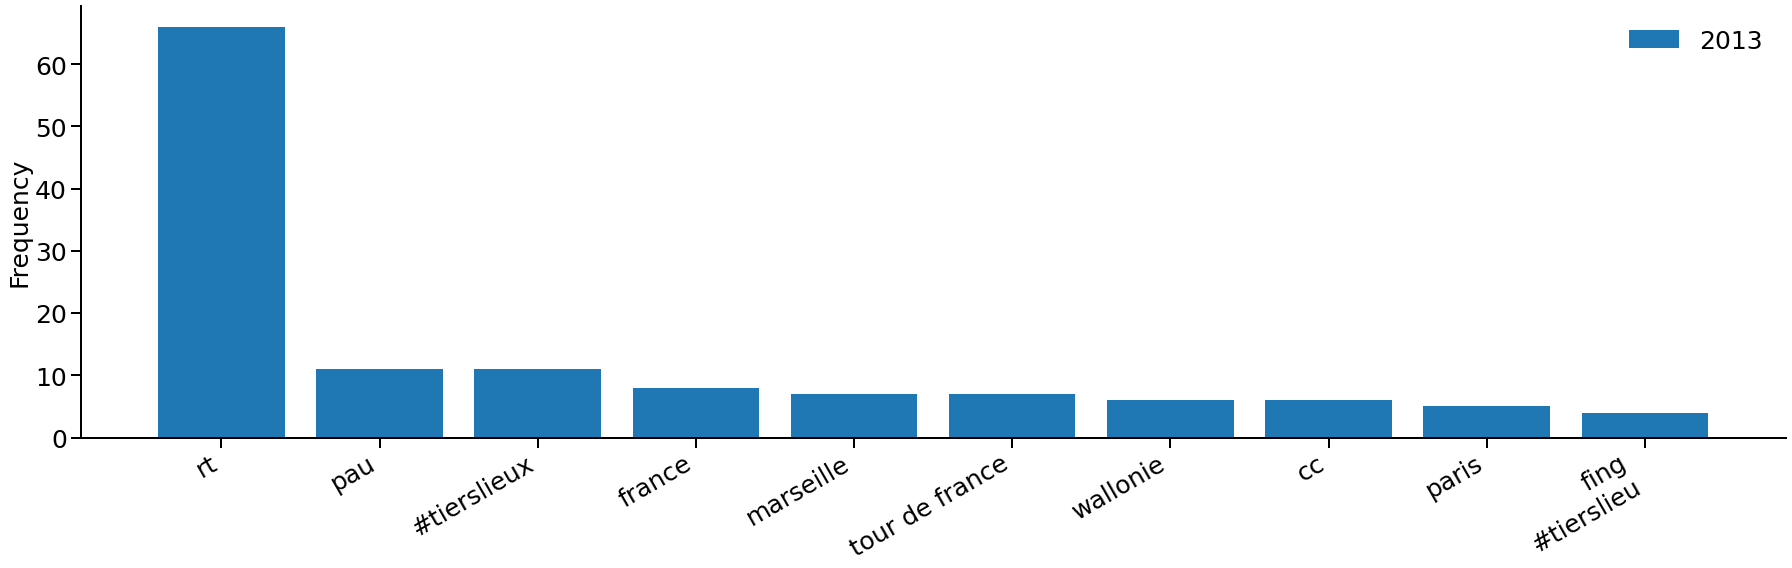

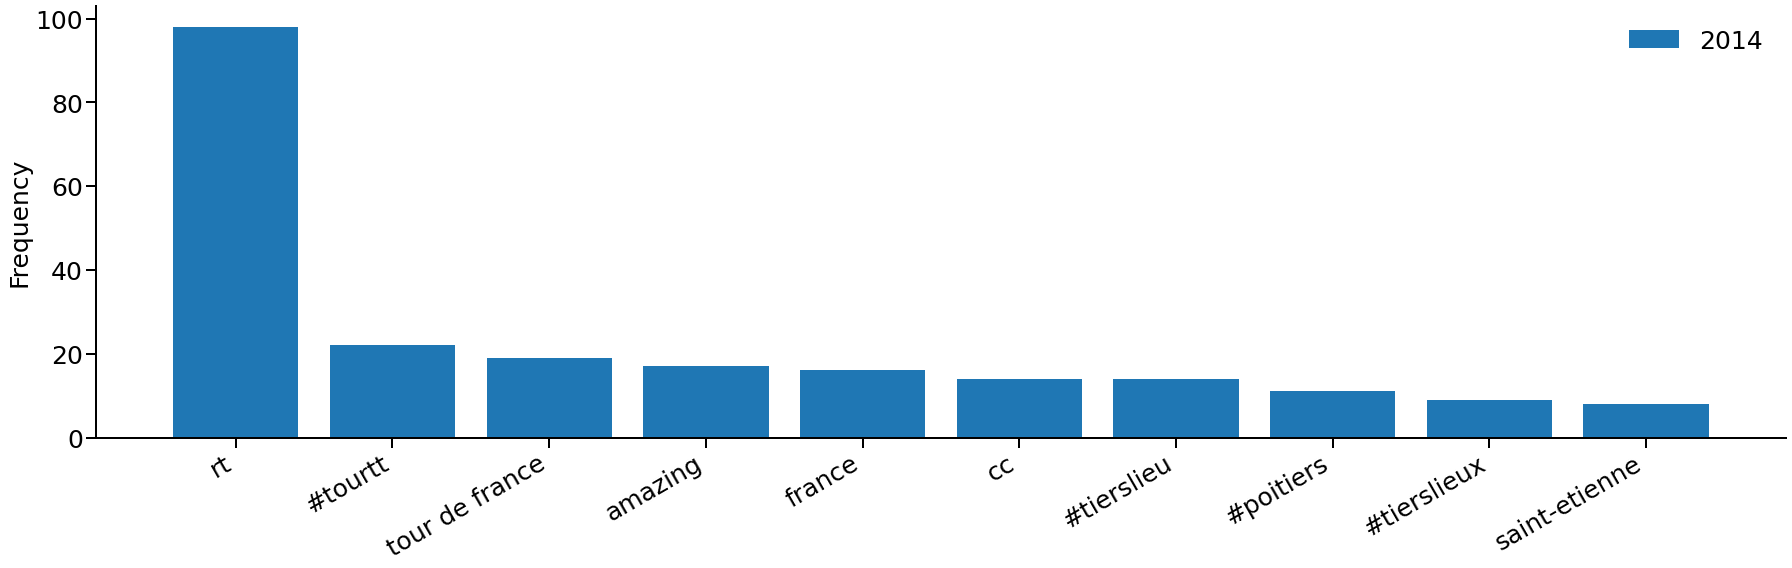

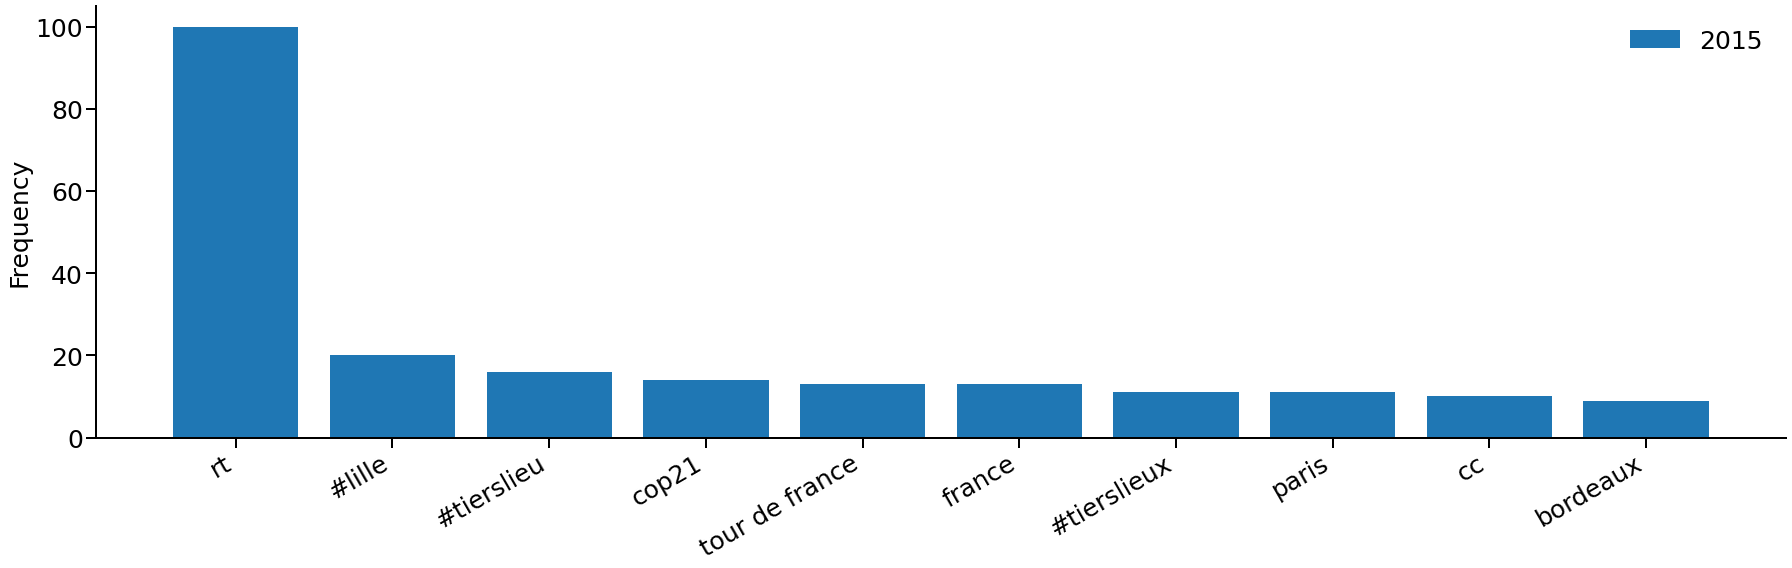

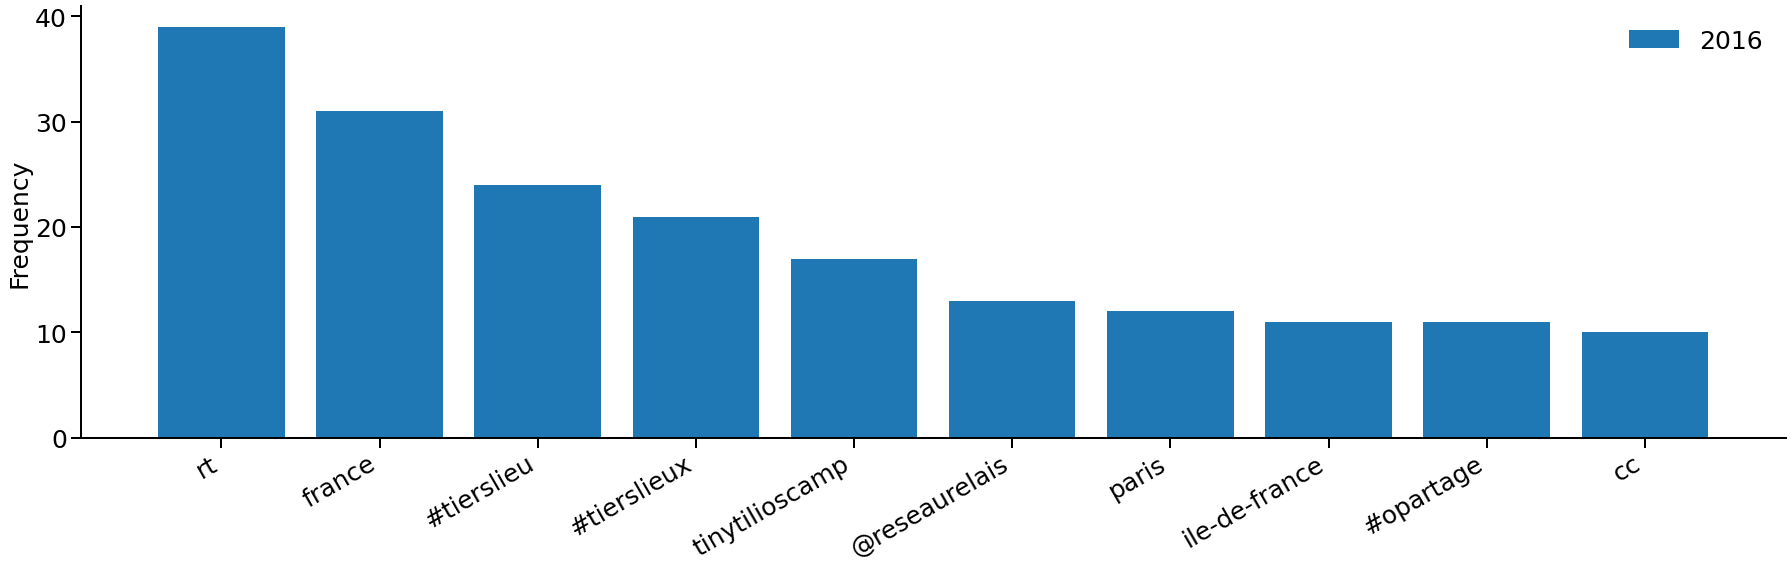

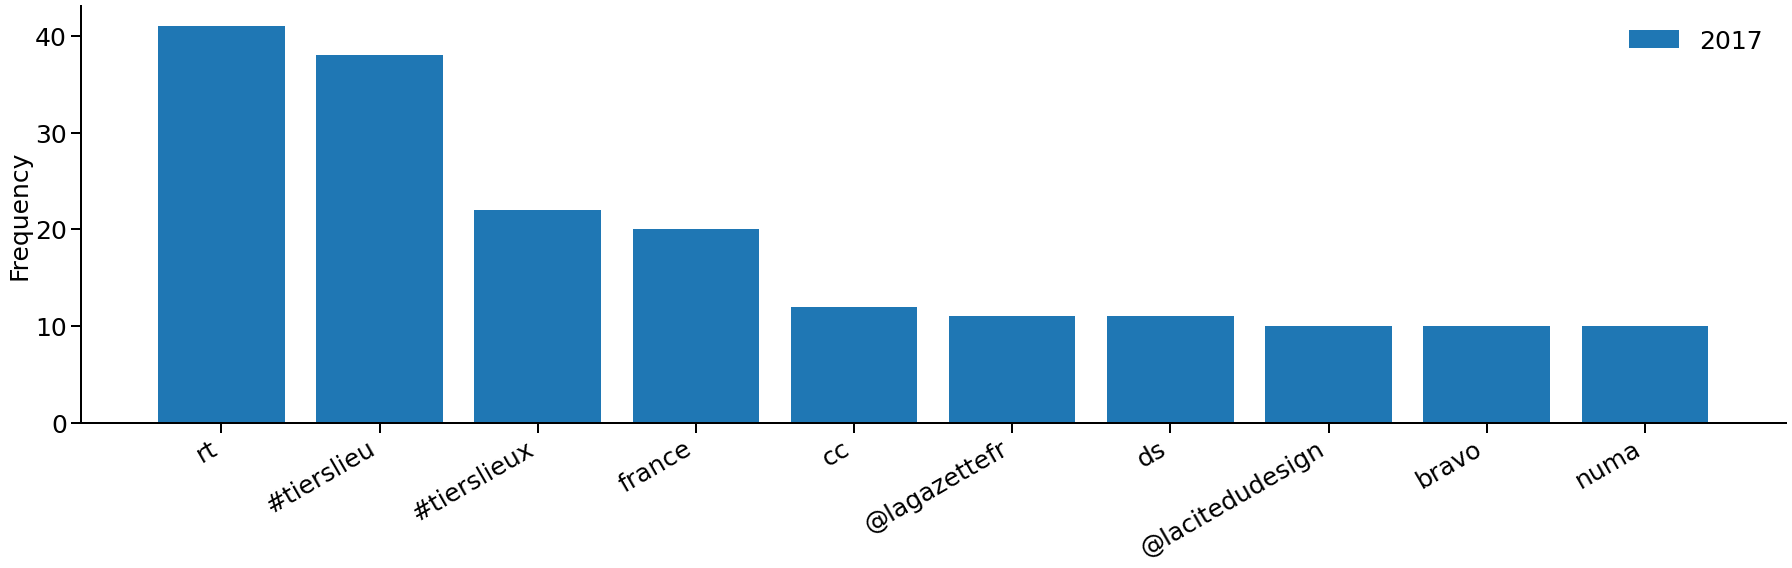

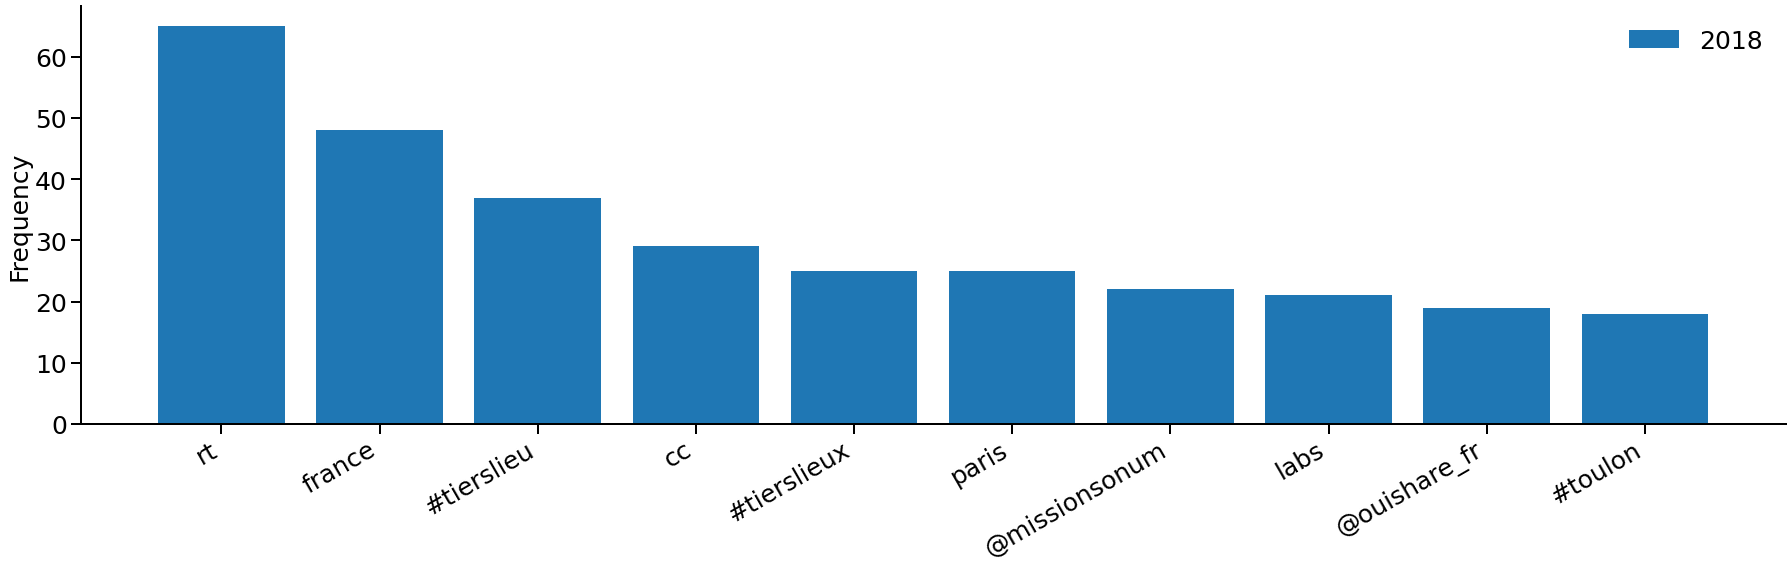

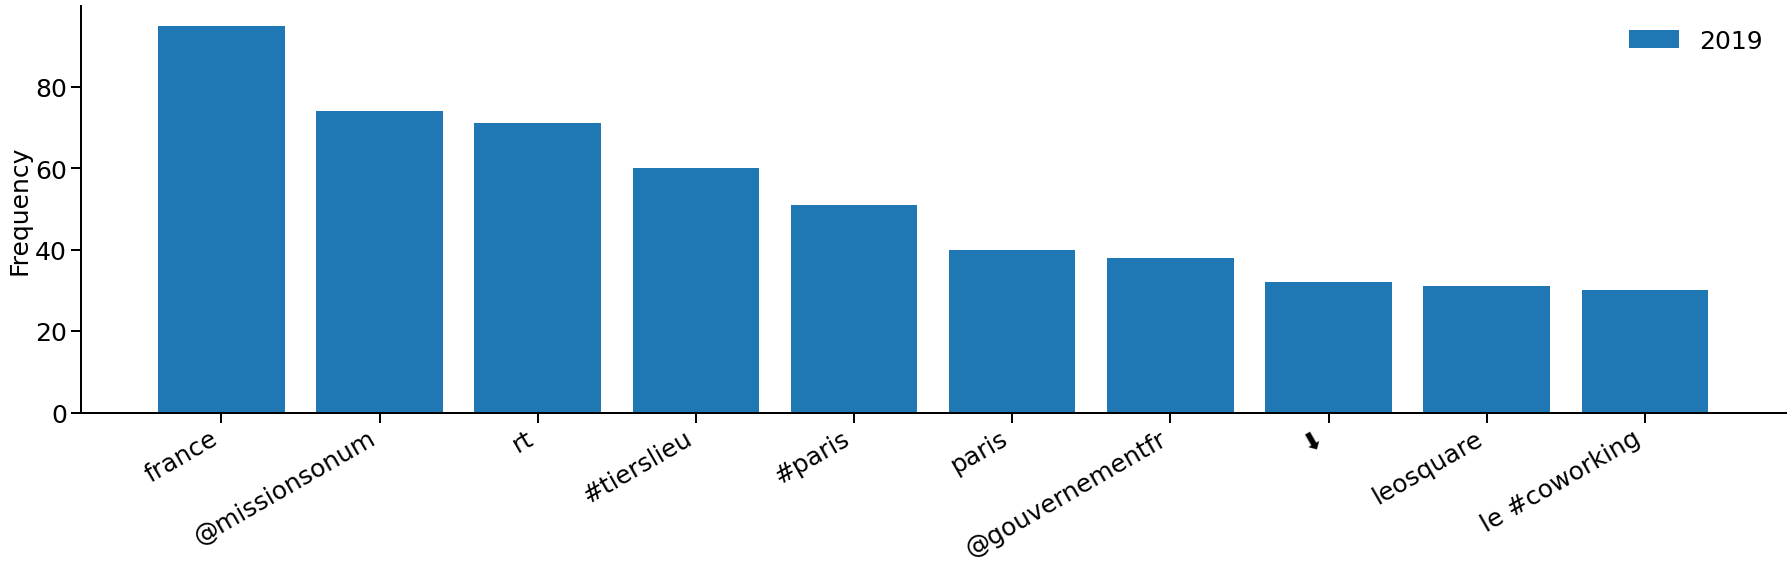

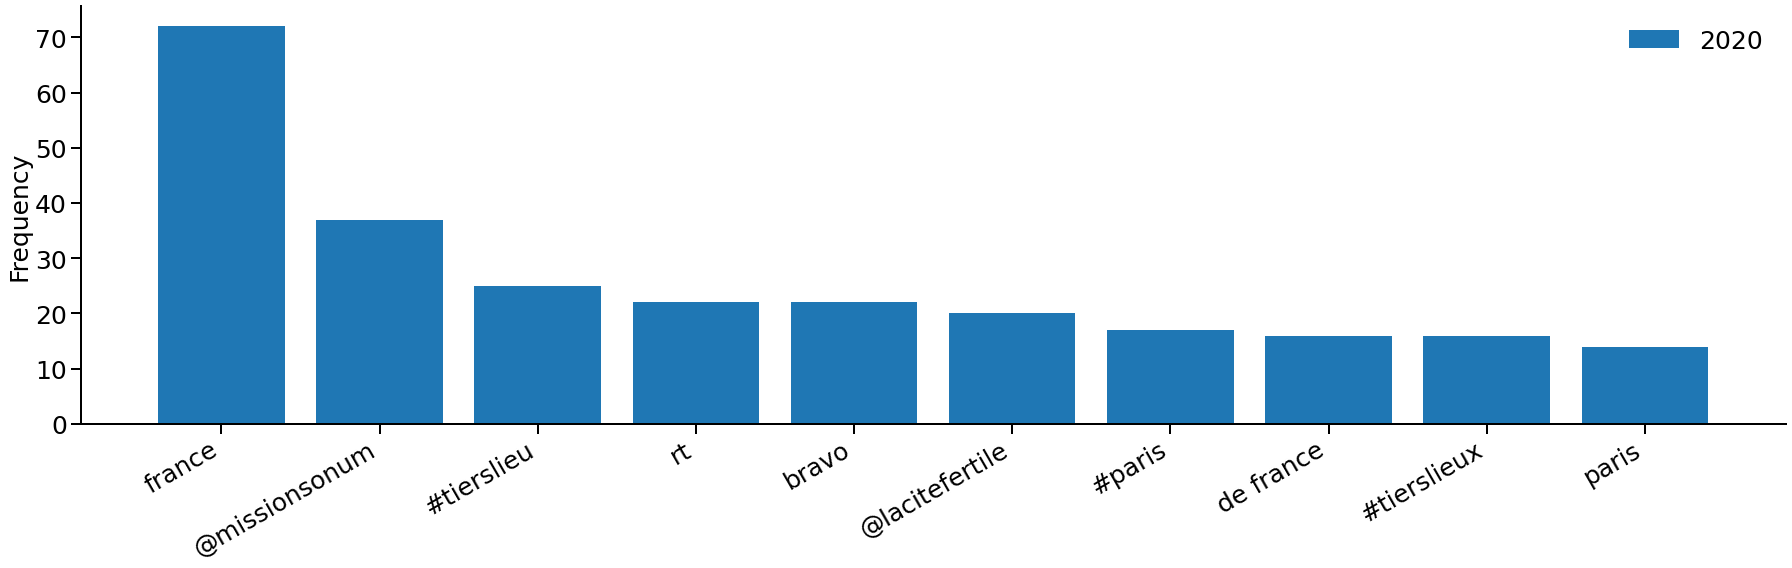

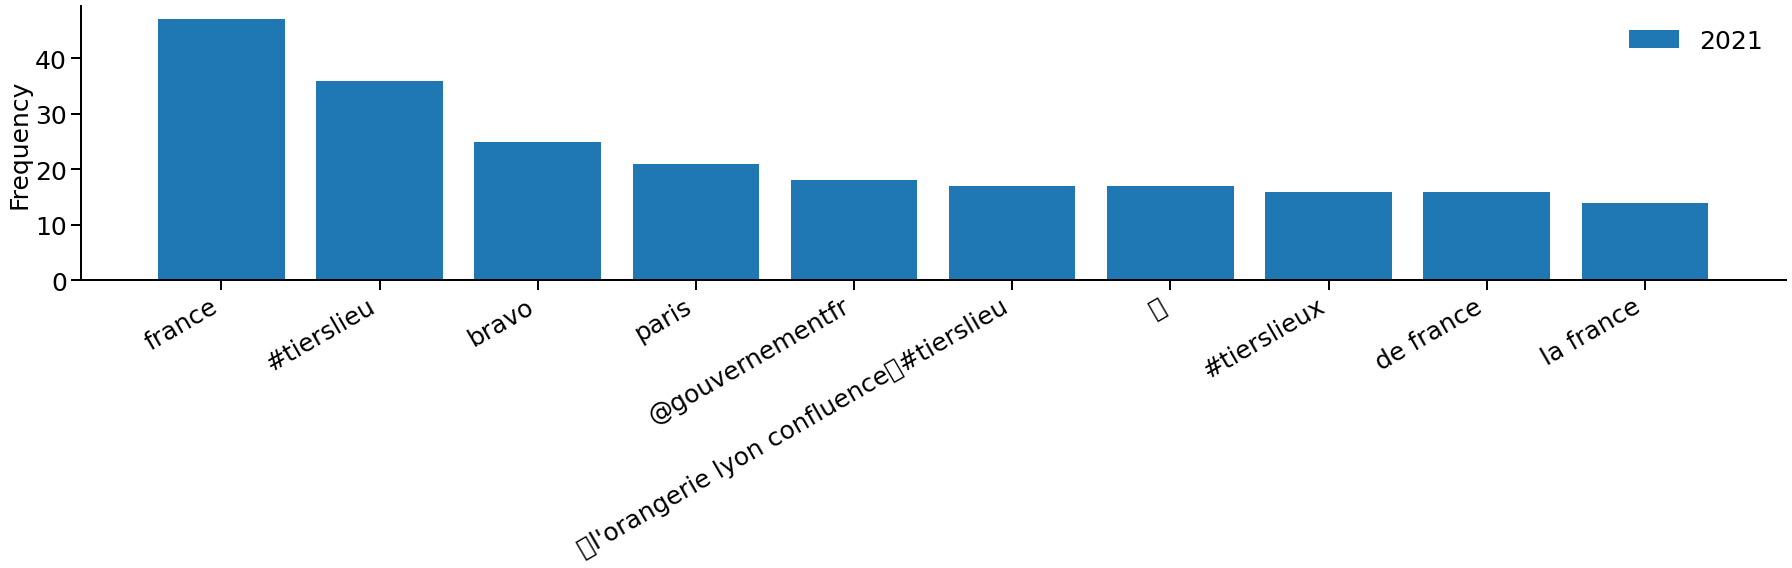

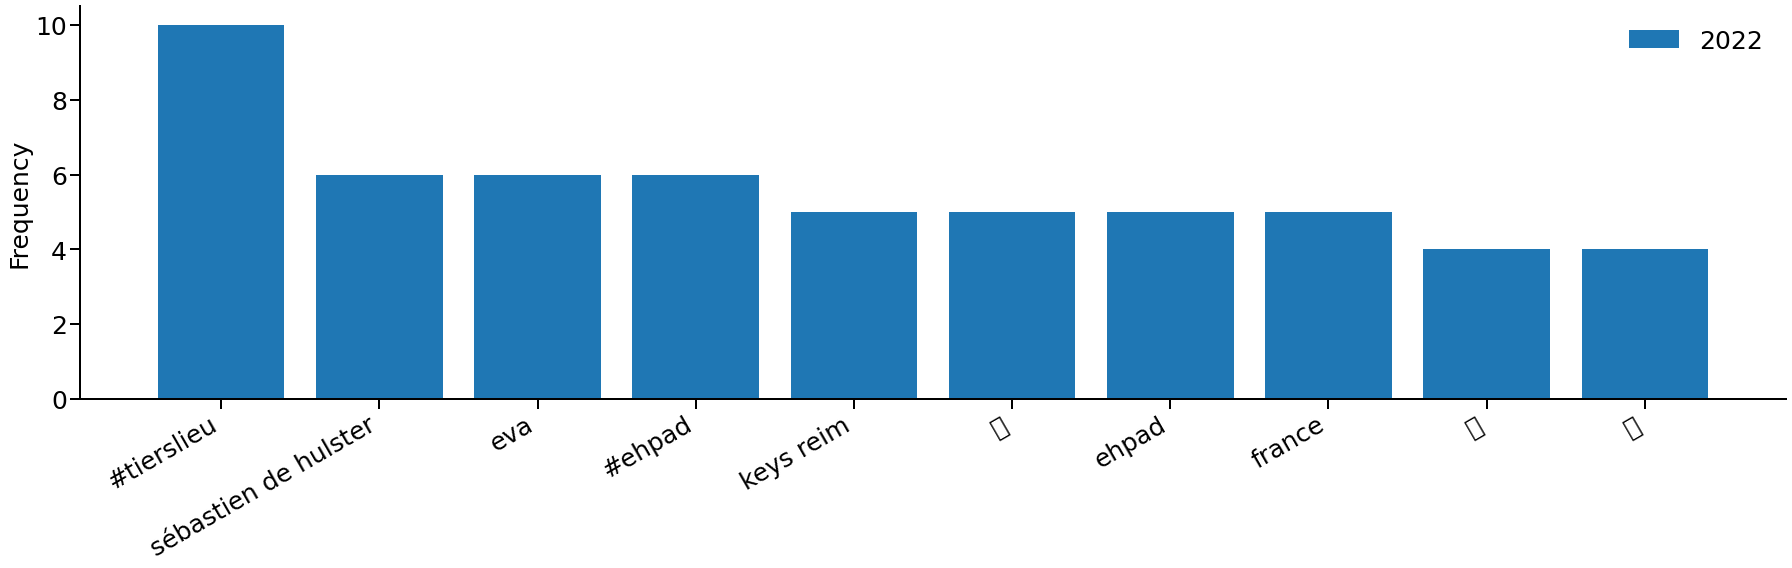

In [17]:
year_topic_list, year_tweet_num_list = ([] for x in range(2))
year_hashtag_list, year_hastag_num_list = ([] for x in range(2))

nlp = spacy.load('fr_core_news_lg')

for year in years[1:]:
    df_year = df_combined.copy(deep=True)
    df_year = df_year[df_year['year']==year]
    temp_documents = list(df_year['text'].str.lower())

    year_tweet_num_list.append(len(df_year))

    temp_word_of_the_year = []

    for td in temp_documents:
        temp_doc = nlp(td)
        for ent in temp_doc.ents:
            temp_word_of_the_year.append(ent.text.lower())  

    word_year = Counter(temp_word_of_the_year)
    word_year = sorted(word_year.items(),key=(lambda i: i[1]))

    final_word_year_list,final_word_num_year_list = ([] for x in range(2))
    for dd in range(10):
        final_word_year_list.append(word_year[-dd-1][0])
        final_word_num_year_list.append(word_year[-dd-1][1])

    plot_freq(10,final_word_num_year_list,final_word_year_list,str(year))

    print(year,' is done.')
      
    